In [1]:
from functools import partial
import numpy as np
import pandas as pd
import pandera as pa
from sklearn.ensemble import RandomForestClassifier

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from simpler_mpl import set_common_mpl_styles, set_commas

In [2]:
# Population
TRAIN_SIZE = 100_000
# ML
TEST_SIZE = 50_000  # 0.3 # 0.3 means 30% test set size

# SIZE = 500_000
# TEST_SIZE = 100_000
VAL_SIZE = TEST_SIZE
BASE_CHURN = 0.16  # 16% churn means 84% retention

features = ["mkt_neg", "bad_exp", "mkt_pos", "brand_loyal"]

In [3]:
# rng.binomial(nbr events e.g. 1 means 0 or 1, p is probability of True, size is nbr of items to generate)

# a bad_exp means they had a problem (e.g. bad insurance claim, hard time with mobile phone tech support),
# this increases their likelihood of churn
# mkt_neg means they really don't like getting marketing and this will increase their likelihood of churn
# gets_mkting is a 50/50 split for Treatment (True) or Control (False)


def make_ppl(nbr_rows, base_churn, seed=0):
    rng = np.random.default_rng(seed=seed)
    ppl = pd.DataFrame(
        {
            "brand_loyal": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if they just love to renew
            "bad_exp": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if they had a bad experience with company
            "mkt_neg": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if receiving marketing will increase churn probability for them
            "mkt_pos": rng.binomial(
                1, 0.25, nbr_rows
            ),  # True if marketing helps retain this customer
        }
    )
    # ppl["prob_churn"] = BASE_CHURN  # # a reasonably standard churn rate
    ppl["prob_churn"] = rng.uniform(base_churn - 0.02, base_churn + 0.02, nbr_rows)
    return ppl

In [4]:
def determine_churners(ppl, marketing_prop, seed=0):
    """People churn based the marketing_prop==[0.0, 1.0] who receive marketing,
    1.0 means all get it, 0 means none, 0.5 means half"""
    ppl = ppl.copy()
    rng = np.random.default_rng(seed=seed)
    nbr_rows = ppl.shape[0]
    assert (
        marketing_prop >= 0 and marketing_prop <= 1.0
    ), "Must be [0, 1] as a proportion"
    ppl["gets_mkting"] = rng.binomial(1, marketing_prop, nbr_rows)
    # people who like marketing and who get marketing have a lower chance of churning
    mask_mkt_pos = (ppl["mkt_pos"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask_mkt_pos, "prob_churn"] -= 0.1

    # people who hate marketing and who get marketing have a higher chance of churning
    mask_mkt_neg = (ppl["mkt_neg"] & ppl["gets_mkting"]) == 1  # trues are 1s (ints)
    ppl.loc[mask_mkt_neg, "prob_churn"] += 0.1  

    # people who have had a negative experience have a higher chance of churn
    mask_bad_exp = ppl["bad_exp"] == 1
    ppl.loc[mask_bad_exp, "prob_churn"] += 0.2

    # people who like the brand experience have a lower chance of churn
    mask_brand_loyal = ppl["brand_loyal"] == 1
    ppl.loc[mask_brand_loyal, "prob_churn"] -= 0.2

    ppl["prob_churn"] = ppl["prob_churn"].clip(lower=0, upper=1)
    ppl["will_churn"] = rng.binomial(1, ppl["prob_churn"], ppl.shape[0])
    return ppl


# TODO uplift_test should be 1.0, not 0.999
marketing_props = {
    "uplift_train": 0.5,
    "uplift_test": 0.5,
    "uplift_val": 1.0,
    "churn_train": 0.0, # market to 0%
    "churn_test": 0.0, # market to 0%
    #"churn_train": 1.0, # market 100%
    #"churn_test": 1.0, # market 100% 
    #"churn_train": 0.5, # market 50%
    #"churn_test": 0.5, # market 50% 
    "churn_val": 1.0,
}
model_type = "churn"
ppl_train = determine_churners(
    make_ppl(TRAIN_SIZE, BASE_CHURN),
    marketing_prop=marketing_props[f"{model_type}_train"],
)
ppl_test = determine_churners(
    make_ppl(TEST_SIZE, BASE_CHURN),
    marketing_prop=marketing_props[f"{model_type}_test"],
)
ppl_val = determine_churners(
    make_ppl(VAL_SIZE, BASE_CHURN), marketing_prop=marketing_props[f"{model_type}_val"]
)

X_train = ppl_train[features]
X_test = ppl_test[features]
X_val = ppl_val[features]
y_train = ppl_train["will_churn"]
y_test = ppl_test["will_churn"]
y_val = ppl_val["will_churn"]

ppl = pd.concat((ppl_train, ppl_test))
assert ppl.shape[1] == ppl_train.shape[1]

ppl.sample(5)  # sample from whole population

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
1576,0,0,0,1,0.160745,0,0
17072,0,0,0,0,0.168215,0,0
86280,0,0,0,0,0.172956,0,0
79805,1,0,0,0,0.000000,0,0
4562,1,0,0,1,0.000000,0,0


In [5]:
percentiles = [0.01, 0.05, 0.5, 0.95, 0.99]
ppl_train.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,100000.000000,100000.000000,100000.000000,100000.000000,100000.000000,100000.0,100000.000000
mean,0.249160,0.248500,0.250310,0.252100,0.167407,0.0,0.165820
std,0.432529,0.432145,0.433194,0.434221,0.111012,0.0,0.371921
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160029,0.0,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.369522,0.0,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.377913,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.380000,0.0,1.000000


In [6]:
ppl_test.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000
mean,0.250140,0.248180,0.248620,0.248380,0.167238,0.0,0.165540
std,0.433098,0.431961,0.432217,0.432078,0.111160,0.0,0.371671
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160097,0.0,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.369113,0.0,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.378040,0.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.379998,0.0,1.000000


In [7]:
ppl_val.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000,50000.0,50000.000000
mean,0.250140,0.248180,0.248620,0.248380,0.169471,1.0,0.168020
std,0.433098,0.431961,0.432217,0.432078,0.121624,0.0,0.373888
min,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
1%,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
5%,0.000000,0.000000,0.000000,0.000000,0.000000,1.0,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.160137,1.0,0.000000
95%,1.000000,1.000000,1.000000,1.000000,0.374865,1.0,1.000000
99%,1.000000,1.000000,1.000000,1.000000,0.468910,1.0,1.000000
max,1.000000,1.000000,1.000000,1.000000,0.479993,1.0,1.000000


In [8]:
ppl.describe(percentiles=percentiles)

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
count,150000.000000,150000.000000,150000.000000,150000.00000,150000.000000,150000.0,150000.000000
mean,0.249487,0.248393,0.249747,0.25086,0.167351,0.0,0.165727
std,0.432717,0.432083,0.432868,0.43351,0.111061,0.0,0.371836
min,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000
1%,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000
5%,0.000000,0.000000,0.000000,0.00000,0.000000,0.0,0.000000
50%,0.000000,0.000000,0.000000,0.00000,0.160050,0.0,0.000000
95%,1.000000,1.000000,1.000000,1.00000,0.369399,0.0,1.000000
99%,1.000000,1.000000,1.000000,1.00000,0.377966,0.0,1.000000
max,1.000000,1.000000,1.000000,1.00000,0.380000,0.0,1.000000


In [9]:
# calc nbr and percentage ppl who churn given probability estimates
# ppl["prob_churn_bin"] = pd.cut(ppl["prob_churn"], bins=10)
# display(ppl.groupby("prob_churn_bin")["will_churn"].sum())
# display(
#    ppl.groupby("prob_churn_bin")["will_churn"].sum()
#    / ppl.groupby("prob_churn_bin")["will_churn"].size()
# )
# ppl = ppl.drop(columns="prob_churn_bin")

In [10]:
ppl.head()

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.157282,0,0
1,0,0,0,1,0.164466,0,0
2,0,0,0,0,0.173355,0,0
3,0,1,1,0,0.348802,0,0
4,1,1,1,0,0.179528,0,0


In [11]:
ppl

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.157282,0,0
1,0,0,0,1,0.164466,0,0
2,0,0,0,0,0.173355,0,0
3,0,1,1,0,0.348802,0,0
4,1,1,1,0,0.179528,0,0
...,...,...,...,...,...,...,...
49995,0,0,1,0,0.179026,0,0
49996,0,0,0,0,0.173363,0,0
49997,0,1,0,0,0.365374,0,1
49998,0,0,0,0,0.161764,0,0


In [12]:
# check that mkt_neg people have a greater prob_churn than non-mkt_neg ppl for a 2 sample ttest

# COULD DO
# prob_churn and will_churn should be reasonably similar (to 2dp?)

schema = pa.DataFrameSchema(
    {
        "bad_exp": pa.Column(int, pa.Check.isin([0, 1])),
        "brand_loyal": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_neg": pa.Column(int, pa.Check.isin([0, 1])),
        "mkt_pos": pa.Column(int, pa.Check.isin([0, 1])),
        # gets_mkting should be circa 50%
        "gets_mkting": pa.Column(
            int,
            [
                pa.Check.isin([0, 1]),
                # TODO should check no mkting for train, mkting for test
                # pa.Check(lambda s: s.mean() > 0.45),
                # pa.Check(lambda s: s.mean() < 0.55),
            ],
        ),
        "will_churn": pa.Column(int, pa.Check.isin([0, 1])),
        # prob_churn bounded [0, 1] and if mkt_neg is True then prob_churn should be greater than if mkt_neg if False
        "prob_churn": pa.Column(
            float,
            [
                pa.Check.le(1.0),
                pa.Check.ge(0),
                # pa.Hypothesis.two_sample_ttest(
                #    sample1=1,
                #    sample2=0,
                #    groupby="mkt_neg",
                #    relationship="greater_than",
                #    alpha=0.05,
                #    equal_var=True,
                # ),
            ],
        ),
    },
    strict=True,
    ordered=False,
)
schema.validate(
    ppl,
    lazy=True,
)
schema.validate(
    ppl_val,
    lazy=True,
);

# Look at some examples of those who do or don't churn

In [13]:
ppl.query("will_churn==True and prob_churn > @BASE_CHURN")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
13,0,1,1,0,0.358790,0,1
15,0,0,0,0,0.171891,0,1


In [14]:
ppl.query("will_churn==False")[:2]

,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
0,0,0,0,1,0.157282,0,0
1,0,0,0,1,0.164466,0,0


# Start to prepare for ML

In [15]:
ppl.columns

Index(['brand_loyal', 'bad_exp', 'mkt_neg', 'mkt_pos', 'prob_churn',
       'gets_mkting', 'will_churn'],
      dtype='object')

In [16]:
assert len(set(features)) == len(features), "Not expecting duplicates"
print(f"Using: {features}")

# check we've not forgotten any columns as new features
non_features = (
    set(ppl.columns)
    .difference(set(features))
    .difference({"will_churn", "prob_churn", "gets_mkting"})
)

if len(non_features) > 0:
    print(f"IGNORING !!!!!!! {non_features}")
    1 / 0  # we shouldn't get here

Using: ['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']


In [17]:
# ppl_train, ppl_test, X_train, X_test, y_train, y_test = train_test_split(
#    ppl, ppl[features], ppl["will_churn"], test_size=TEST_SIZE, shuffle=True
# )
print(list(x.shape for x in [ppl_train, ppl_test, X_train, X_test, y_train, y_test]))

[(100000, 7), (50000, 7), (100000, 4), (50000, 4), (100000,), (50000,)]


In [18]:
est_dummy = DummyClassifier(strategy="prior")
est_dummy.fit(X_train, y_train)

dummy_proba_pos = est_dummy.predict_proba(X_test)[:, 1]
log_loss(y_test, dummy_proba_pos)

0.4487436143122763

In [19]:
base_model = LogisticRegression
# base_model = partial(RandomForestClassifier, n_estimators=5)

In [20]:
churn_model = base_model
# churn_model = LogisticRegression
# churn_model = partial(RandomForestClassifier, n_estimators=10)
est_churn = churn_model()
est_churn.fit(X_train, y_train)
print(f"Fitting churn model with {churn_model}")

y_pred = est_churn.predict_proba(X_test)
y_pred_proba_pos = y_pred[:, 1]
log_loss(y_test, y_pred_proba_pos)

Fitting churn model with <class 'sklearn.linear_model._logistic.LogisticRegression'>


0.40043490000239945

# Gains chart

Note if T prob guessed more-wrong than C prob then it is possible for a decreasing gains line.

In [21]:
del ppl_test, ppl
del ppl_train
del X_train, X_test
del y_train, y_test

In [22]:
keys = ["churn_proba_pos", "dummy_proba_pos"]

In [23]:
result = pd.DataFrame({"y_true": y_val})

result["churn_proba_pos"] = est_churn.predict_proba(X_val)[:, 1]
result["dummy_proba_pos"] = est_dummy.predict_proba(X_val)[:, 1]
for key in keys:
    assert key in result.columns

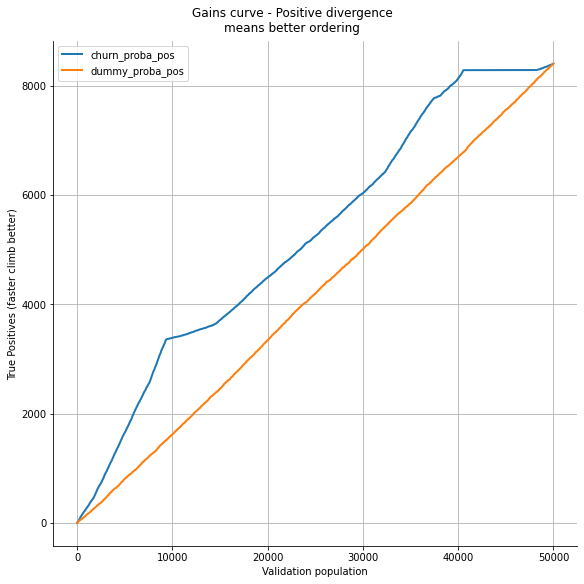

In [24]:
fig, ax = plt.subplots(figsize=(8, 8), constrained_layout=True)
fig.suptitle("Gains curve - Positive divergence\nmeans better ordering")
for key in keys:
    linestyle = "-"
    linewidth = 2
    if key in {"up_proba_c", "up_proba_t"}:
        linestyle = "--"
        linewidth = 1

    result_sorted = result.sort_values(key, ascending=False).reset_index()
    result_sorted["y_true_cum"] = result_sorted["y_true"].cumsum()
    result_sorted.plot(
        kind="line",
        y="y_true_cum",
        ax=ax,
        label=key,
        linestyle=linestyle,
        linewidth=linewidth,
    )
ax.set_ylabel("True Positives (faster climb better)")
ax.set_xlabel("Validation population")

set_common_mpl_styles(ax, grid_axis="both")
# set_commas(ax, True, True)

# # zoom on x axis
# ax.set_xlim((45_000, result.shape[0]-1));
# ax.set_ylim(ymin=6000);

In [84]:
test_merged = pd.merge(
    left=result,
    right=ppl_val,
    left_index=True,
    right_index=True,
    validate="one_to_one",
)
assert test_merged.shape[0] == TEST_SIZE
test_merged.sample(10).sort_values("prob_churn").drop(
    columns=[] #"dummy_proba_pos", "churn_proba_pos"]
)

,y_true,churn_proba_pos,dummy_proba_pos,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn
8892,0,0.025626,0.16582,1,0,0,0,0.000000,1,0
21080,0,0.148311,0.16582,0,0,0,1,0.046890,1,0
13492,0,0.025328,0.16582,1,0,1,0,0.060016,1,0
40147,0,0.148311,0.16582,0,0,0,1,0.064503,1,0
41421,0,0.148311,0.16582,0,0,0,1,0.065801,1,0
43984,0,0.146960,0.16582,0,0,0,0,0.140707,1,0
26694,0,0.145459,0.16582,0,0,1,0,0.242295,1,0
402,1,0.145459,0.16582,0,0,1,0,0.245247,1,1
35939,0,0.386489,0.16582,0,1,1,0,0.476847,1,0
41482,0,0.386489,0.16582,0,1,1,0,0.478231,1,0


In [85]:
# test_merged["uplift_diff_t_c_bins"] = pd.cut(test_merged["uplift_diff_t_c"], 3)
test_merged["churn_proba_pos_bins"] = pd.cut(test_merged["churn_proba_pos"], 3)

# test_merged['uplift_diff_t_c_bins'] = pd.qcut(test_merged['uplift_diff_t_c'], 4)
features

['mkt_neg', 'bad_exp', 'mkt_pos', 'brand_loyal']

# For each row in the test set, group and explain the features

If we order the data by predicted use of marketing to increase lift, we can count the underlying features - these should reflect the original distributions.

* sure things - have `brand_loyal` and don't respond to marketing, they're likelier to _stay_
* lost causes - have `bad_experience` and don't respond to marketing, they're likelier to _leave_
* persuadables - have `mkt_pos` as they respond well if marketed to, they're likelier to _stay_ conditional on marketing
* sleeping dogs - have `mkt_neg` as they respond negatively if marketed to, they're likelier to _leave_ conditional on marketing

In [86]:
def make_pretty(styler, title):
    styler.set_caption(title)
    # styler.format(rain_condition)
    # styler.format_index(lambda v: v.strftime("%A"))
    # styler.background_gradient(axis='columns', vmin=1, vmax=5, cmap="YlGnBu")
    styler.background_gradient(axis="rows", cmap="YlGnBu")
    return styler

In [87]:
res = test_merged.groupby("dummy_proba_pos").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
)
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
display(
    "churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn"
)
res.style.pipe(make_pretty, "Feature contributions to Churn prediction")

'Base churn rate for all is circa 16.0%'

'churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum
dummy_proba_pos,,,,,,
0.16582,50000,0.168020,12419,12409,12507,12431


In [88]:
res = test_merged.groupby("churn_proba_pos_bins").agg(
    count=pd.NamedAgg("mkt_neg", "size"),
    prob_churn_if_mktd=pd.NamedAgg("will_churn", "mean"),
    mkt_pos_sum=pd.NamedAgg("mkt_pos", "sum"),
    bad_exp_sum=pd.NamedAgg("bad_exp", "sum"),
    brand_loyal_sum=pd.NamedAgg("brand_loyal", "sum"),
    mkt_neg_sum=pd.NamedAgg("mkt_neg", "sum"),
)
display(f"Base churn rate for all is circa {BASE_CHURN*100:0.1f}%")
display(
    "churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn"
)
res.style.pipe(make_pretty, "Feature contributions to Churn prediction")

'Base churn rate for all is circa 16.0%'

'churn_proba_pos_bins is prob(churn), typically we market at the people with highest chance of churn'

,count,prob_churn_if_mktd,mkt_pos_sum,bad_exp_sum,brand_loyal_sum,mkt_neg_sum
churn_proba_pos_bins,,,,,,
"(0.025, 0.148]",35473,0.134187,4916,3073,12507,10115
"(0.148, 0.27]",5191,0.055095,5191,0,0,0
"(0.27, 0.392]",9336,0.359362,2312,9336,0,2316


# Estimate value to business

In [97]:
# TODO note we're not checking if we do want to market...?
def calculate_value_generated(dfx, col, ascending):
    print(f"Sorting on {col} by ascending {ascending}")
    df_costing = dfx.sort_values(col, ascending=ascending).copy().reset_index(drop=True)
    df_costing['price_if_mktd'] = -10
    df_costing['price_if_mktd_cumsum'] = df_costing['price_if_mktd'].cumsum()
    df_costing['price_if_retained'] = 100 * (df_costing['will_churn']==0)
    df_costing['value_generated_cumsum'] = df_costing['price_if_retained'].cumsum()
    return df_costing
df_costing = calculate_value_generated(test_merged, 'churn_proba_pos_bins', False)
df_costing

Sorting on churn_proba_pos_bins by ascending False


,y_true,churn_proba_pos,dummy_proba_pos,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn,churn_proba_pos_bins,price_if_mktd,price_if_mktd_cumsum,price_if_retained,value_generated_cumsum
0,1,0.386489,0.16582,0,1,1,0,0.460934,1,1,"(0.27, 0.392]",-10,-10,0,0
1,0,0.386489,0.16582,0,1,1,0,0.463595,1,0,"(0.27, 0.392]",-10,-20,100,100
2,1,0.386489,0.16582,0,1,1,0,0.442534,1,1,"(0.27, 0.392]",-10,-30,0,100
3,1,0.389345,0.16582,0,1,0,0,0.358583,1,1,"(0.27, 0.392]",-10,-40,0,100
4,0,0.386489,0.16582,0,1,1,0,0.473726,1,0,"(0.27, 0.392]",-10,-50,100,200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0.025626,0.16582,1,0,0,0,0.000000,1,0,"(0.025, 0.148]",-10,-499960,100,4159600
49996,0,0.146960,0.16582,0,0,0,0,0.177117,1,0,"(0.025, 0.148]",-10,-499970,100,4159700
49997,1,0.146960,0.16582,0,0,0,0,0.163765,1,1,"(0.025, 0.148]",-10,-499980,0,4159700
49998,0,0.145459,0.16582,0,0,1,0,0.258479,1,0,"(0.025, 0.148]",-10,-499990,100,4159800


Writing to df_comparison_churn.pickle with Index(['churn_proba_pos', 'cumsum_value_churn'], dtype='object')


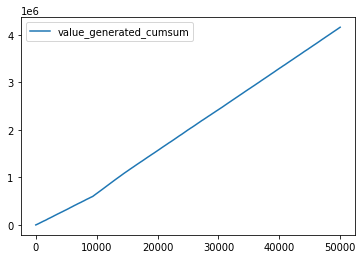

In [113]:
df_comparison = df_costing[['churn_proba_pos', 'value_generated_cumsum']].rename(columns={'value_generated_cumsum': 'cumsum_value_churn'})
OUTFILE = "df_comparison_churn.pickle"
print(f"Writing to {OUTFILE} with {df_comparison.columns}")
df_comparison.to_pickle(OUTFILE)
df_costing.plot(kind='line', y='value_generated_cumsum');

In [105]:
test_merged

,y_true,churn_proba_pos,dummy_proba_pos,brand_loyal,bad_exp,mkt_neg,mkt_pos,prob_churn,gets_mkting,will_churn,churn_proba_pos_bins
0,0,0.146960,0.16582,0,0,0,0,0.150944,1,0,"(0.025, 0.148]"
1,1,0.389345,0.16582,0,1,0,0,0.350176,1,1,"(0.27, 0.392]"
2,0,0.146960,0.16582,0,0,0,0,0.169986,1,0,"(0.025, 0.148]"
3,1,0.386489,0.16582,0,1,1,0,0.474642,1,1,"(0.27, 0.392]"
4,0,0.025328,0.16582,1,0,1,0,0.070837,1,0,"(0.025, 0.148]"
...,...,...,...,...,...,...,...,...,...,...,...
49995,0,0.145459,0.16582,0,0,1,0,0.279026,1,0,"(0.025, 0.148]"
49996,0,0.146960,0.16582,0,0,0,0,0.173363,1,0,"(0.025, 0.148]"
49997,0,0.389345,0.16582,0,1,0,0,0.365374,1,0,"(0.27, 0.392]"
49998,0,0.146960,0.16582,0,0,0,0,0.161764,1,0,"(0.025, 0.148]"


Sorting on dummy_proba_pos by ascending True
Writing to df_comparison_dummy.pickle with Index(['dummy_proba_pos', 'cumsum_value_dummy'], dtype='object')


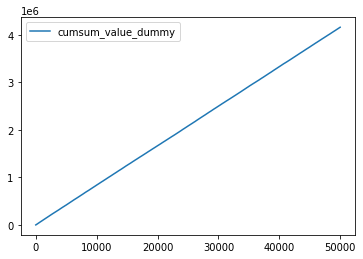

In [111]:
df_costing_dummy = calculate_value_generated(test_merged, 'dummy_proba_pos', True)

df_comparison = df_costing_dummy[['dummy_proba_pos', 'value_generated_cumsum']].rename(columns={'value_generated_cumsum': 'cumsum_value_dummy'})
OUTFILE = "df_comparison_dummy.pickle"
print(f"Writing to {OUTFILE} with {df_comparison.columns}")
df_comparison.to_pickle(OUTFILE)

df_comparison.plot(kind='line', y='cumsum_value_dummy');